<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train NN</a></span><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>main()</a></span><ul class="toc-item"><li><span><a href="#Plot" data-toc-modified-id="Plot-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#test-example:-2d" data-toc-modified-id="test-example:-2d-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>test example: 2d</a></span><ul class="toc-item"><li><span><a href="#fully-connected-in-sklearn" data-toc-modified-id="fully-connected-in-sklearn-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>fully connected in sklearn</a></span></li><li><span><a href="#fully-connected-in-keras" data-toc-modified-id="fully-connected-in-keras-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>fully connected in keras</a></span></li><li><span><a href="#cnn" data-toc-modified-id="cnn-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>cnn</a></span></li></ul></li></ul></li></ul></div>

# import libs

In [28]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
sys.path.append(confParser['input files']['lib_path'])
from dscribe.descriptors import SOAP, ACSF
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
#
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
#
from scipy.stats import gaussian_kde
#
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['flags', 'input files', 'EnergyBarrier', 'neural net']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# Train NN

In [39]:
class NeuralNetwork():

    def __init__(self, verbose=False,
                **kwargs
                ):
        self.verbose = verbose
        for key in kwargs:
            setattr(self,key,kwargs[key])
    
    def Parse(self,path,nruns):
        self.perAtomData = {}
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            try:
                #--- same configurations!
                self.descriptors  = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['data']]
                self.shape        = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['shape']].flatten()
                self.positions    = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['xyz']]
                data = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                #--- displacement data
                self.perAtomData[irun] = pd.DataFrame(np.c_[data],
                columns='id	type	x	y	z	ux	uy	uz	energy_barrier	defect_label'.split()
                            )
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns = list(self.perAtomData.keys())
        self.nruns.sort()
        
    def Combine(self):
#         pdb.set_trace()
        #--- center atoms
        center_atom_indices = list(map(lambda x:NeuralNetwork.GetCenterAtom( self.perAtomData[x])[0],self.nruns))
        sdict = dict(zip(center_atom_indices,self.nruns))
        
        atom_ids = list(sdict.keys())
        atom_ids.sort()
        #         center_atom_indices = list( set( center_atom_indices ) )
        data = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[sdict[x]].iloc[ x ]],atom_ids)),axis=1).T
        descriptors_center_atoms = self.descriptors[atom_ids]
    
        #--- data frame
#        print(data.shape)
        irun = self.nruns[0]
        df_combined = pd.DataFrame(data,columns=list(self.perAtomData[irun].keys()))
    
        #--- filter crystaliine atoms
        filtr = self.perAtomData[irun].defect_label == 0.0
        df_crystalline = self.perAtomData[irun][filtr]
        descriptors_crystalline = self.descriptors[filtr]

        #--- merge
        keys = list(df_combined.keys())
        data_concat = np.concatenate([np.c_[df_combined[keys]],np.c_[df_crystalline[keys]]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=keys
                             )

        
        #--- merge descriptors
        self.descriptors = np.concatenate([descriptors_center_atoms,descriptors_crystalline],axis=0)

        assert self.perAtomData.shape[ 0 ] == self.descriptors.shape[0], 'need more mc swaps: %s %s'\
        %(self.perAtomData.shape[ 0 ],self.descriptors.shape[0])
                            
                                 
    
    @staticmethod
    def GetCenterAtom(df):
        disp_magnitude = df.ux**2+df.uy**2+df.uz**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)

    @staticmethod
    def zscore(slist):
        tmp = np.copy(slist)
        print(np.mean(tmp),np.std(tmp))
        tmp -= np.mean(tmp)
        tmp /= np.std(tmp)
        return tmp

    def PCA(self,
           n_components=2,
            random_state = 1,
           ):
        #--- concat. data
        X = self.descriptors
        pca = PCA(n_components=n_components,random_state=random_state)
        pca.fit(X)
        X_transformed = pca.transform(X)

        xdata = X_transformed[:,0]
        ydata = X_transformed[:,1]
        #
        filtr_defects = self.perAtomData.defect_label == 0.0
        #

        legend = utl.Legends()
        legend.Set(bbox_to_anchor=(1.1,.5, 0.5, 0.5))
#         pdb.set_trace()
        #ax = utl.PltErr(zscore(xdata)[filtr_defects],zscore(ydata)[filtr_defects],
        ax = utl.PltErr(xdata[filtr_defects],ydata[filtr_defects],
                  attrs={'fmt':'x','alpha':1,'label':'defect_free'},
                        Plot = False,
        #                 xlim=(-2,2),
        #                 ylim=(-2,2),
                  )

        #utl.PltErr(zscore(xdata)[~filtr_defects],zscore(ydata)[~filtr_defects],
        !mkdir png
        utl.PltErr(xdata[~filtr_defects],ydata[~filtr_defects],
                  attrs={'fmt':'.','color':'red','label':'defects'},
                   ax=ax,
                   xstr='pca_1',ystr='pca_2',
                   legend = legend.Get(),
                   title='png/pca.png'
                  )
    def Spectra(self,
               nrows=100,
               ):
        assert nrows <= self.descriptors.shape[ 0 ]
        !mkdir png
        utl.PltBitmap(np.log10(np.abs(self.descriptors[:nrows,:])),
                      xlabel=r'$\mathrm{ndim}$',ylabel=r'$\mathrm{natom}$',
                      xlim=(0,self.descriptors.shape[1]),
                      ylim=(0,nrows),
                      colorbar=True,
                      zscore=False,
                      vminmax=(-3,3),
                      title='png/feature_bitmap.png'
                     )
        
    def TrainClassifier(self,y,
                       random_state=1,
                       ):
        #--- train-test split
        X = np.c_[self.descriptors]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        #--- tune parameters
        param_grid = {
                        'hidden_layer_sizes':self.hidden_layer_sizes,
                         #'activation' : ['tanh', 'relu'],
                         'learning_rate_init':self.learning_rate_init,
                        'alpha':self.alpha, #--- regularization 
                         #'learning_rate' : ['invscaling', 'adaptive'],
                        'n_iter_no_change':self.n_iter_no_change,
                        'tol':self.tol,
                        'max_iter':self.max_iter,

                     } 

        #--- train
        mlp = MLPClassifier(random_state=random_state)
        clf = GridSearchCV(mlp, param_grid)
        clf.fit(X_train,y_train)

        #--- validate
        !mkdir png
        utl.PltErr(range(len(clf.best_estimator_.loss_curve_)), clf.best_estimator_.loss_curve_,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )


        #--- confusion matrix
        cm = confusion_matrix(y_test, clf.predict(X_test),
                         labels=[0, 1]
                        )
        print('cm=',cm)

    def TrainRegressor(self,stratify,y,
                       random_state=1,
                       printOvito = False,
                       filtr = None,
                       ):
        '''
        Multi-layer Perceptron regressor.

        Parameters
        ----------
        stratify : array-like, default=None
        If not None, data is split in a stratified fashion, using this as
        the class labels.
        
        y : array-like, target data
        
        random_state : initial seed, default=1
        
        printOvito : bool, default=False
        
        filtr : bool, default=False
        if not None, data is filtered before calling train-test split
        '''
        if self.verbose:
            print('dim(y)=',y.shape)

        ndime  = y.shape[1] #--- dimension of the target vector
        
        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors[filtr]]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify,
                                                            random_state=random_state)

        #-----------------------
        #--- parameter grid
        #-----------------------
        param_grid = {
                        'hidden_layer_sizes':self.hidden_layer_sizes,
                         #'activation' : ['tanh', 'relu'],
                         'learning_rate_init':self.learning_rate_init,
                        'alpha':self.alpha, #--- regularization 
                         #'learning_rate' : ['invscaling', 'adaptive'],
                        'n_iter_no_change':self.n_iter_no_change,
                        'tol':self.tol,
                        'max_iter':self.max_iter,
                     } 

        #-----------------------
        #--- train model
        #-----------------------
        if self.fully_connected: #--- dense nn
            if self.implementation == 'sklearn':
                mlp   =  MLPRegressor(random_state=random_state,verbose=self.verbose) #--- mlp regressor
                regr  =  GridSearchCV(mlp, param_grid)
                regr.fit(X_train,y_train)
                model =  regr.best_estimator_
                loss  =  model.loss_curve_
                
            elif self.implementation == 'keras': #--- dense nn in keras
                model     = keras.Sequential([ #--- The network architecture
                    layers.Dense(self.hidden_layer_size), #activation="relu"),
                    layers.Dense(self.hidden_layer_size), #activation="relu"),
                    #layers.Dense(1000), #activation="relu"),
                    layers.Dense(ndime) #, activation="relu")
                    ])
                optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4) #--- compilation step
                model.compile( optimizer=optimizer,#"rmsprop",
                               loss="mean_squared_error",#"sparse_categorical_crossentropy",
                               metrics=["mse"]
                             )
                model.fit(X_train, y_train, #--- “Fitting”
                          validation_data=(X_test, y_test),
                          epochs=self.max_iter[0], verbose=self.verbose)#, batch_size=128)
                loss      = model.history.history['loss']
                val_loss  = model.history.history['val_loss']
                
        elif self.cnn: #--- convolutional
            (model, loss, val_loss), (X_train, X_test) =\
            self.ConvNetwork(X_train, y_train, X_test, y_test )
            

        #-----------------------
        #--- validation
        #-----------------------
        !mkdir png         #--- plot validation loss 
        ax = utl.PltErr(range(len(val_loss)), val_loss,
                   attrs={'fmt':'-'}, Plot=False,
                  )
        utl.PltErr(range(len(loss)), loss,
                   attrs={'fmt':'-'},
                   ax=ax,
                   yscale='log',xscale='log',
                   xlim=(1,self.max_iter[0]),
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )
        
        np.savetxt('png/loss.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')
        
        #--- plot predictions
        y_pred       = model.predict(X_test)        
        y_pred_train = model.predict(X_train)        
        for idime, xstr in zip(range(3),'ux uy uz'.split()):
            ax = utl.PltErr(None,None,Plot=False)
            #
            utl.PltErr(y_test[:,idime],y_pred[:,idime],
                       attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
                       attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(None,None,Plot=False,
                           title='png/scatter%s.png'%idime,
                            ax=ax,
                       xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
                       xlim=(-2,2),ylim=(-2,2),
                           )
        
        #--- save in ovito
        if printOvito:
            X_train, X_test, _, _ = train_test_split(self.perAtomData[filtr]['id type x y z'.split()], y, stratify=stratify,
                                                    random_state=random_state)
#            pdb.set_trace()
            with open('original.xyz','w') as fp:
                utl.PrintOvito(self.perAtomData[filtr], fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('train.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_train,y_pred_train],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('test.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_test,y_pred],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
                

    def ConvNetwork(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "mean_squared_error",
                       metrics   =  ["mse"]
                     )

        #--- save best model
        !mkdir best_model
        callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
                                                   monitor="loss",
                                                  save_freq=10,
                                                    save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
                   callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
                    use_multiprocessing = True,
                    workers             = 4,
                 )

        #--- validation loss
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    

    def ConvNetworkClassifier(self,y,
                               random_state=1
                               ):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
        
        if self.verbose:
            print('dim(y)=',y.shape)

        ndime  = y.shape[1] #--- dimension of the target vector
        

        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors ]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        if self.verbose:
            print('X.shape:=',X.shape)
            
            
            
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        
        
        #---- set model parameters
        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  100 #self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #
#         pdb.set_trace()
        #------------------------------
        #--- The network architecture
        #------------------------------
        model     = keras.Sequential([
            layers.Dense(self.hidden_layer_size, activation="relu"),
#             layers.Dense(self.hidden_layer_size), #activation="relu"),
            layers.Dense(2, activation="softmax")
            ])
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) #--- compilation step

        model.compile( optimizer="rmsprop",
                       loss="sparse_categorical_crossentropy",
                       metrics=["mse"])

        #--- save best model
        !mkdir best_model
        callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
                                                    monitor="loss",
                                                    save_freq=10,
                                                    save_best_only=True)]


        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train 
        X_test_reshaped  =  X_test
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
                    callbacks=callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
                    use_multiprocessing = True,
                    workers             = 4,
                 )        




        #--- validation loss
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = keras.models.load_model("best_model/convnetClassifier_from_scratch.tf")

        
        !mkdir png
        utl.PltErr(range(len(val_loss)), val_loss,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/val_loss_classification.png',
                  )
        
        np.savetxt('png/val_loss_classification.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')


#         pdb.set_trace()
        #--- confusion matrix
        predict_x = best_model.predict(X_test) 
        classes_x = np.argmax(predict_x,axis=1)
        cm = confusion_matrix(y_test, classes_x,
                         labels=[0, 1]
                        )
        print('cm=',cm)
        np.savetxt('png/confusion.txt',np.c_[cm])
    

    
    def PrintDensityMap(self, atomIndx, fout):
        with open(fout,'w') as fp:
                    disp           = np.c_[self.perAtomData.iloc[atomIndx]['ux uy uz'.split()]].flatten()
                    df             = pd.DataFrame(np.c_[self.positions.T,self.descriptors[atomIndx]],
                                                  columns='x y z mass'.split())
                    utl.PrintOvito(df, fp, 'disp = %s'%disp, attr_list='x y z mass'.split())
    def SaveConf(self,fout):
        with open(fout,'w') as fp:
            np.savetxt(fp,np.c_[self.perAtomData],header=' '.join(list(self.perAtomData.keys())))

## main()

dim(y)= (1366, 1)
X.shape:= (1366, 1331)
mkdir: cannot create directory ‘best_model’: File exists
Train on 1024 samples, validate on 342 samples
Epoch 1/100
1024/1024 [==============================] - 0s 404us/sample - loss: 0.0735 - acc: 0.9756 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2/100
1024/1024 [==============================] - 0s 222us/sample - loss: 5.1679e-04 - acc: 1.0000 - val_loss: 1.8377e-04 - val_acc: 1.0000
Epoch 3/100
 544/1024 [==============>...............] - ETA: 0s - loss: 1.1444e-04 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 225us/sample - loss: 8.0369e-05 - acc: 1.0000 - val_loss: 2.9624e-05 - val_acc: 1.0000
Epoch 4/100
1024/1024 [==============================] - 0s 217us/sample - loss: 1.2876e-05 - acc: 1.0000 - val_loss: 5.3243e-06 - val_acc: 1.0000
Epoch 5/100
1024/1024 [==============================] - 0s 228us/sample - loss: 2.3511e-06 - acc: 1.0000 - val_loss: 1.1402e-06 - val_acc: 1.0000
Epoch 6/100
  32/1024 [..............................] - ETA: 0s - loss: 9.0524e-07 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 219us/sample - loss: 5.1118e-07 - acc: 1.0000 - val_loss: 2.8443e-07 - val_acc: 1.0000
Epoch 7/100
1024/1024 [==============================] - 0s 218us/sample - loss: 1.2852e-07 - acc: 1.0000 - val_loss: 8.3307e-08 - val_acc: 1.0000
Epoch 8/100
 576/1024 [===============>..............] - ETA: 0s - loss: 5.1947e-08 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 213us/sample - loss: 3.9930e-08 - acc: 1.0000 - val_loss: 2.6840e-08 - val_acc: 1.0000
Epoch 9/100
1024/1024 [==============================] - 0s 227us/sample - loss: 8.9640e-09 - acc: 1.0000 - val_loss: 1.2200e-08 - val_acc: 1.0000
Epoch 10/100
1024/1024 [==============================] - 0s 229us/sample - loss: 4.7730e-09 - acc: 1.0000 - val_loss: 8.7141e-09 - val_acc: 1.0000
Epoch 11/100
 288/1024 [=======>......................] - ETA: 0s - loss: 4.1392e-09 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 225us/sample - loss: 3.1432e-09 - acc: 1.0000 - val_loss: 6.2742e-09 - val_acc: 1.0000
Epoch 12/100
1024/1024 [==============================] - 0s 227us/sample - loss: 2.5611e-09 - acc: 1.0000 - val_loss: 4.8799e-09 - val_acc: 1.0000
Epoch 13/100
1024/1024 [==============================] - 0s 229us/sample - loss: 2.0955e-09 - acc: 1.0000 - val_loss: 4.1828e-09 - val_acc: 1.0000
Epoch 14/100
1024/1024 [==============================] - 0s 224us/sample - loss: 1.5134e-09 - acc: 1.0000 - val_loss: 3.4857e-09 - val_acc: 1.0000
Epoch 15/100
1024/1024 [==============================] - 0s 227us/sample - loss: 9.3132e-10 - acc: 1.0000 - val_loss: 3.1371e-09 - val_acc: 1.0000
Epoch 16/100
 544/1024 [==============>...............] - ETA: 0s - loss: 6.5740e-10 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 237us/sample - loss: 9.3132e-10 - acc: 1.0000 - val_loss: 1.7428e-09 - val_acc: 1.0000
Epoch 17/100
1024/1024 [==============================] - 0s 224us/sample - loss: 8.1491e-10 - acc: 1.0000 - val_loss: 1.7428e-09 - val_acc: 1.0000
Epoch 18/100
1024/1024 [==============================] - 0s 232us/sample - loss: 6.9849e-10 - acc: 1.0000 - val_loss: 1.7428e-09 - val_acc: 1.0000
Epoch 19/100
  32/1024 [..............................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 229us/sample - loss: 5.8208e-10 - acc: 1.0000 - val_loss: 1.7428e-09 - val_acc: 1.0000
Epoch 20/100
1024/1024 [==============================] - 0s 226us/sample - loss: 5.8208e-10 - acc: 1.0000 - val_loss: 1.7428e-09 - val_acc: 1.0000
Epoch 21/100
 832/1024 [=======================>......] - ETA: 0s - loss: 4.2984e-10 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 223us/sample - loss: 3.4925e-10 - acc: 1.0000 - val_loss: 1.3943e-09 - val_acc: 1.0000
Epoch 22/100
1024/1024 [==============================] - 0s 223us/sample - loss: 3.4925e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 23/100
1024/1024 [==============================] - 0s 231us/sample - loss: 3.4925e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 24/100
 288/1024 [=======>......................] - ETA: 0s - loss: 4.1392e-10 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 225us/sample - loss: 3.4925e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 25/100
1024/1024 [==============================] - 0s 214us/sample - loss: 3.4925e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 26/100
1024/1024 [==============================] - 0s 227us/sample - loss: 3.4925e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 27/100
  32/1024 [..............................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 225us/sample - loss: 3.4925e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 28/100
1024/1024 [==============================] - 0s 223us/sample - loss: 3.4925e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 29/100
 544/1024 [==============>...............] - ETA: 0s - loss: 2.1913e-10 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 215us/sample - loss: 3.4925e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 30/100
1024/1024 [==============================] - 0s 213us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 31/100
1024/1024 [==============================] - 0s 225us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 32/100
 320/1024 [========>.....................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 229us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 33/100
1024/1024 [==============================] - 0s 222us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 1.0457e-09 - val_acc: 1.0000
Epoch 34/100
1024/1024 [==============================] - 0s 232us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 6.9713e-10 - val_acc: 1.0000


Epoch 35/100
1024/1024 [==============================] - 0s 218us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 6.9713e-10 - val_acc: 1.0000
Epoch 36/100
1024/1024 [==============================] - 0s 215us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 6.9713e-10 - val_acc: 1.0000
Epoch 37/100
 544/1024 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 226us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 38/100
1024/1024 [==============================] - 0s 220us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 39/100
1024/1024 [==============================] - 0s 221us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 40/100
  32/1024 [..............................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 228us/sample - loss: 2.3283e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 41/100
1024/1024 [==============================] - 0s 225us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 42/100
 768/1024 [=====================>........] - ETA: 0s - loss: 1.5522e-10 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 232us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 43/100
1024/1024 [==============================] - 0s 254us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 44/100
1024/1024 [==============================] - 0s 233us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 45/100
 288/1024 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 230us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 46/100
1024/1024 [==============================] - 0s 260us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 47/100
1024/1024 [==============================] - 0s 260us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 48/100


1024/1024 [==============================] - 0s 232us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 49/100
1024/1024 [==============================] - 0s 234us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 50/100
 544/1024 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 235us/sample - loss: 1.1642e-10 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 51/100
1024/1024 [==============================] - 0s 247us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 52/100
1024/1024 [==============================] - 0s 222us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 53/100
  32/1024 [..............................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 247us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 54/100
1024/1024 [==============================] - 0s 231us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 3.4857e-10 - val_acc: 1.0000
Epoch 55/100
 768/1024 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 237us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 56/100
1024/1024 [==============================] - 0s 233us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 57/100
1024/1024 [==============================] - 0s 253us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 58/100
 288/1024 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 245us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 59/100
1024/1024 [==============================] - 0s 232us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 60/100
1024/1024 [==============================] - 0s 197us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


Epoch 61/100
1024/1024 [==============================] - 0s 197us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 62/100
1024/1024 [==============================] - 0s 193us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 63/100
 608/1024 [================>.............] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 192us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 64/100
1024/1024 [==============================] - 0s 194us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 65/100
1024/1024 [==============================] - 0s 193us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 66/100
  32/1024 [..............................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 191us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 67/100
1024/1024 [==============================] - 0s 201us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 68/100
1024/1024 [==============================] - 0s 194us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 69/100
1024/1024 [==============================] - 0s 193us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 70/100
1024/1024 [==============================] - 0s 193us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 71/100
 320/1024 [========>.....................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 192us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 72/100
1024/1024 [==============================] - 0s 196us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 73/100
1024/1024 [==============================] - 0s 194us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 74/100
  32/1024 [..............................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 191us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 75/100
1024/1024 [==============================] - 0s 195us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 76/100
 608/1024 [================>.............] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 192us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 77/100
1024/1024 [==============================] - 0s 198us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 78/100
1024/1024 [==============================] - 0s 207us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 79/100
1024/1024 [==============================] - 0s 195us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 80/100
1024/1024 [==============================] - 0s 192us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 81/100
 896/1024 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 193us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 82/100
1024/1024 [==============================] - 0s 193us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 83/100
1024/1024 [==============================] - 0s 191us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 84/100
 320/1024 [========>.....................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 195us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 85/100
1024/1024 [==============================] - 0s 195us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 86/100
1024/1024 [==============================] - 0s 195us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 87/100
  32/1024 [..............................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 196us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 88/100
1024/1024 [==============================] - 0s 193us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 89/100
 608/1024 [================>.............] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 192us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 90/100
1024/1024 [==============================] - 0s 197us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 91/100
1024/1024 [==============================] - 0s 193us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 92/100
 320/1024 [========>.....................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 194us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 93/100
1024/1024 [==============================] - 0s 194us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 94/100
1024/1024 [==============================] - 0s 195us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 95/100


1024/1024 [==============================] - 0s 193us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 96/100
1024/1024 [==============================] - 0s 195us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 97/100
 608/1024 [================>.............] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 194us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 98/100
1024/1024 [==============================] - 0s 195us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 99/100
1024/1024 [==============================] - 0s 191us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 100/100
  32/1024 [..............................] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


1024/1024 [==============================] - 0s 195us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
mkdir: cannot create directory ‘png’: File exists


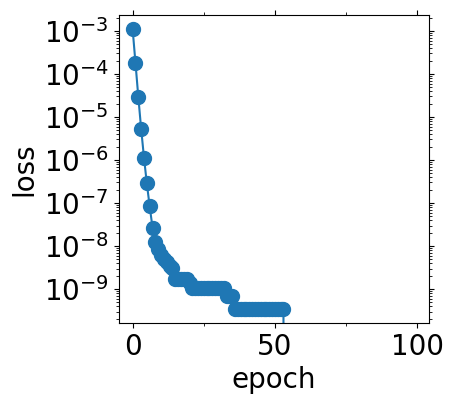

cm= [[340   0]
 [  0   2]]
dim(y)= (7, 3)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 11, 11, 11, 1)]   0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 11, 11, 11, 16)    448       
_________________________________________________________________
average_pooling3d_9 (Average (None, 5, 5, 5, 16)       0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 5, 5, 5, 32)       13856     
_________________________________________________________________
average_pooling3d_10 (Averag (None, 2, 2, 2, 32)       0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
average_pooling3d

Epoch 33/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9759 - mean_squared_error: 1.9759 - val_loss: 1.9923 - val_mean_squared_error: 1.9923
Epoch 34/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9754 - mean_squared_error: 1.9754 - val_loss: 1.9923 - val_mean_squared_error: 1.9923
Epoch 35/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9750 - mean_squared_error: 1.9750 - val_loss: 1.9923 - val_mean_squared_error: 1.9923
Epoch 36/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9746 - mean_squared_error: 1.9746 - val_loss: 1.9923 - val_mean_squared_error: 1.9923
Epoch 37/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9742 - mean_squared_error: 1.9742 - val_loss: 1.9924 - val_mean_squared_error: 1.9924
Epoch 38/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9738 - mean_squared_error: 1.9738 - val_loss: 1.9924 - val_mean_squared_error: 1.9924
Epoch 39/2000
5/5 [===

Epoch 74/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9580 - mean_squared_error: 1.9580 - val_loss: 1.9929 - val_mean_squared_error: 1.9929
Epoch 75/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9575 - mean_squared_error: 1.9575 - val_loss: 1.9929 - val_mean_squared_error: 1.9929
Epoch 76/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9570 - mean_squared_error: 1.9570 - val_loss: 1.9929 - val_mean_squared_error: 1.9929
Epoch 77/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9565 - mean_squared_error: 1.9565 - val_loss: 1.9929 - val_mean_squared_error: 1.9929
Epoch 78/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9560 - mean_squared_error: 1.9560 - val_loss: 1.9929 - val_mean_squared_error: 1.9929
Epoch 79/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9555 - mean_squared_error: 1.9555 - val_loss: 1.9929 - val_mean_squared_error: 1.9929
Epoch 80/2000
5/5 [===

5/5 [==============================] - 0s 1ms/sample - loss: 1.9348 - mean_squared_error: 1.9348 - val_loss: 1.9918 - val_mean_squared_error: 1.9918
Epoch 115/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9341 - mean_squared_error: 1.9341 - val_loss: 1.9917 - val_mean_squared_error: 1.9917
Epoch 116/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9334 - mean_squared_error: 1.9334 - val_loss: 1.9916 - val_mean_squared_error: 1.9916
Epoch 117/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9327 - mean_squared_error: 1.9327 - val_loss: 1.9916 - val_mean_squared_error: 1.9916
Epoch 118/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9320 - mean_squared_error: 1.9320 - val_loss: 1.9915 - val_mean_squared_error: 1.9915
Epoch 119/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9313 - mean_squared_error: 1.9313 - val_loss: 1.9914 - val_mean_squared_error: 1.9914
Epoch 120/2000
5/5 [===========

Epoch 155/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8999 - mean_squared_error: 1.8999 - val_loss: 1.9868 - val_mean_squared_error: 1.9868
Epoch 156/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8988 - mean_squared_error: 1.8988 - val_loss: 1.9866 - val_mean_squared_error: 1.9866
Epoch 157/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8978 - mean_squared_error: 1.8978 - val_loss: 1.9864 - val_mean_squared_error: 1.9864
Epoch 158/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8967 - mean_squared_error: 1.8967 - val_loss: 1.9862 - val_mean_squared_error: 1.9862
Epoch 159/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8956 - mean_squared_error: 1.8956 - val_loss: 1.9860 - val_mean_squared_error: 1.9860
Epoch 160/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8945 - mean_squared_error: 1.8945 - val_loss: 1.9858 - val_mean_squared_error: 1.9858
Epoch 161/2000
5

Epoch 196/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8469 - mean_squared_error: 1.8469 - val_loss: 1.9753 - val_mean_squared_error: 1.9753
Epoch 197/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8453 - mean_squared_error: 1.8453 - val_loss: 1.9749 - val_mean_squared_error: 1.9749
Epoch 198/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8437 - mean_squared_error: 1.8437 - val_loss: 1.9745 - val_mean_squared_error: 1.9745
Epoch 199/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8421 - mean_squared_error: 1.8421 - val_loss: 1.9741 - val_mean_squared_error: 1.9741
Epoch 200/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8404 - mean_squared_error: 1.8404 - val_loss: 1.9737 - val_mean_squared_error: 1.9737
Epoch 201/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8388 - mean_squared_error: 1.8388 - val_loss: 1.9733 - val_mean_squared_error: 1.9733
Epoch 202/2000
5

5/5 [==============================] - 0s 1ms/sample - loss: 1.7700 - mean_squared_error: 1.7700 - val_loss: 1.9548 - val_mean_squared_error: 1.9548
Epoch 237/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.7677 - mean_squared_error: 1.7677 - val_loss: 1.9542 - val_mean_squared_error: 1.9542
Epoch 238/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.7653 - mean_squared_error: 1.7653 - val_loss: 1.9535 - val_mean_squared_error: 1.9535
Epoch 239/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.7630 - mean_squared_error: 1.7630 - val_loss: 1.9528 - val_mean_squared_error: 1.9528
Epoch 240/2000
5/5 [==============================] - 0s 2ms/sample - loss: 1.7606 - mean_squared_error: 1.7606 - val_loss: 1.9522 - val_mean_squared_error: 1.9522
Epoch 241/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.7582 - mean_squared_error: 1.7582 - val_loss: 1.9515 - val_mean_squared_error: 1.9515
Epoch 242/2000
5/5 [===========

Epoch 277/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.6583 - mean_squared_error: 1.6583 - val_loss: 1.9215 - val_mean_squared_error: 1.9215
Epoch 278/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.6551 - mean_squared_error: 1.6551 - val_loss: 1.9205 - val_mean_squared_error: 1.9205
Epoch 279/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.6519 - mean_squared_error: 1.6519 - val_loss: 1.9195 - val_mean_squared_error: 1.9195
Epoch 280/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.6487 - mean_squared_error: 1.6487 - val_loss: 1.9185 - val_mean_squared_error: 1.9185
Epoch 281/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.6454 - mean_squared_error: 1.6454 - val_loss: 1.9175 - val_mean_squared_error: 1.9175
Epoch 282/2000
5/5 [==============================] - 0s 2ms/sample - loss: 1.6422 - mean_squared_error: 1.6422 - val_loss: 1.9165 - val_mean_squared_error: 1.9165
Epoch 283/2000
5

Epoch 318/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.5114 - mean_squared_error: 1.5114 - val_loss: 1.8740 - val_mean_squared_error: 1.8740
Epoch 319/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.5075 - mean_squared_error: 1.5075 - val_loss: 1.8726 - val_mean_squared_error: 1.8726
Epoch 320/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.5035 - mean_squared_error: 1.5035 - val_loss: 1.8713 - val_mean_squared_error: 1.8713
Epoch 321/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.4995 - mean_squared_error: 1.4995 - val_loss: 1.8699 - val_mean_squared_error: 1.8699
Epoch 322/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.4955 - mean_squared_error: 1.4955 - val_loss: 1.8686 - val_mean_squared_error: 1.8686
Epoch 323/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.4914 - mean_squared_error: 1.4914 - val_loss: 1.8672 - val_mean_squared_error: 1.8672
Epoch 324/2000
5

5/5 [==============================] - 0s 1ms/sample - loss: 1.3431 - mean_squared_error: 1.3431 - val_loss: 1.8155 - val_mean_squared_error: 1.8155
Epoch 359/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.3387 - mean_squared_error: 1.3387 - val_loss: 1.8139 - val_mean_squared_error: 1.8139
Epoch 360/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.3343 - mean_squared_error: 1.3343 - val_loss: 1.8123 - val_mean_squared_error: 1.8123
Epoch 361/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.3299 - mean_squared_error: 1.3299 - val_loss: 1.8107 - val_mean_squared_error: 1.8107
Epoch 362/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.3256 - mean_squared_error: 1.3256 - val_loss: 1.8092 - val_mean_squared_error: 1.8092
Epoch 363/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.3212 - mean_squared_error: 1.3212 - val_loss: 1.8076 - val_mean_squared_error: 1.8076
Epoch 364/2000
5/5 [===========

Epoch 399/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.1648 - mean_squared_error: 1.1648 - val_loss: 1.7494 - val_mean_squared_error: 1.7494
Epoch 400/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.1606 - mean_squared_error: 1.1606 - val_loss: 1.7477 - val_mean_squared_error: 1.7477
Epoch 401/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.1564 - mean_squared_error: 1.1564 - val_loss: 1.7461 - val_mean_squared_error: 1.7461
Epoch 402/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.1521 - mean_squared_error: 1.1521 - val_loss: 1.7445 - val_mean_squared_error: 1.7445
Epoch 403/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.1479 - mean_squared_error: 1.1479 - val_loss: 1.7429 - val_mean_squared_error: 1.7429
Epoch 404/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.1437 - mean_squared_error: 1.1437 - val_loss: 1.7413 - val_mean_squared_error: 1.7413
Epoch 405/2000
5

Epoch 440/2000
5/5 [==============================] - 0s 2ms/sample - loss: 1.0003 - mean_squared_error: 1.0003 - val_loss: 1.6861 - val_mean_squared_error: 1.6861
Epoch 441/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.9966 - mean_squared_error: 0.9966 - val_loss: 1.6846 - val_mean_squared_error: 1.6846
Epoch 442/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.9928 - mean_squared_error: 0.9928 - val_loss: 1.6832 - val_mean_squared_error: 1.6832
Epoch 443/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.9891 - mean_squared_error: 0.9891 - val_loss: 1.6818 - val_mean_squared_error: 1.6818
Epoch 444/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.9853 - mean_squared_error: 0.9853 - val_loss: 1.6804 - val_mean_squared_error: 1.6804
Epoch 445/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.9816 - mean_squared_error: 0.9816 - val_loss: 1.6789 - val_mean_squared_error: 1.6789
Epoch 446/2000
5

5/5 [==============================] - 0s 1ms/sample - loss: 0.8583 - mean_squared_error: 0.8583 - val_loss: 1.6332 - val_mean_squared_error: 1.6332
Epoch 481/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.8549 - mean_squared_error: 0.8549 - val_loss: 1.6320 - val_mean_squared_error: 1.6320
Epoch 482/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.8516 - mean_squared_error: 0.8516 - val_loss: 1.6308 - val_mean_squared_error: 1.6308
Epoch 483/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.8483 - mean_squared_error: 0.8483 - val_loss: 1.6296 - val_mean_squared_error: 1.6296
Epoch 484/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.8449 - mean_squared_error: 0.8449 - val_loss: 1.6285 - val_mean_squared_error: 1.6285
Epoch 485/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.8416 - mean_squared_error: 0.8416 - val_loss: 1.6273 - val_mean_squared_error: 1.6273
Epoch 486/2000
5/5 [===========

Epoch 521/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.7271 - mean_squared_error: 0.7271 - val_loss: 1.5882 - val_mean_squared_error: 1.5882
Epoch 522/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.7241 - mean_squared_error: 0.7241 - val_loss: 1.5872 - val_mean_squared_error: 1.5872
Epoch 523/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.7210 - mean_squared_error: 0.7210 - val_loss: 1.5862 - val_mean_squared_error: 1.5862
Epoch 524/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.7180 - mean_squared_error: 0.7180 - val_loss: 1.5852 - val_mean_squared_error: 1.5852
Epoch 525/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.7150 - mean_squared_error: 0.7150 - val_loss: 1.5842 - val_mean_squared_error: 1.5842
Epoch 526/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.7119 - mean_squared_error: 0.7119 - val_loss: 1.5832 - val_mean_squared_error: 1.5832
Epoch 527/2000
5

Epoch 562/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.6071 - mean_squared_error: 0.6071 - val_loss: 1.5497 - val_mean_squared_error: 1.5497
Epoch 563/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.6043 - mean_squared_error: 0.6043 - val_loss: 1.5488 - val_mean_squared_error: 1.5488
Epoch 564/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.6016 - mean_squared_error: 0.6016 - val_loss: 1.5479 - val_mean_squared_error: 1.5479
Epoch 565/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.5988 - mean_squared_error: 0.5988 - val_loss: 1.5470 - val_mean_squared_error: 1.5470
Epoch 566/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.5960 - mean_squared_error: 0.5960 - val_loss: 1.5461 - val_mean_squared_error: 1.5461
Epoch 567/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.5932 - mean_squared_error: 0.5932 - val_loss: 1.5453 - val_mean_squared_error: 1.5453
Epoch 568/2000
5

5/5 [==============================] - 0s 1ms/sample - loss: 0.5006 - mean_squared_error: 0.5006 - val_loss: 1.5157 - val_mean_squared_error: 1.5157
Epoch 603/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4981 - mean_squared_error: 0.4981 - val_loss: 1.5148 - val_mean_squared_error: 1.5148
Epoch 604/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4956 - mean_squared_error: 0.4956 - val_loss: 1.5140 - val_mean_squared_error: 1.5140
Epoch 605/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4931 - mean_squared_error: 0.4931 - val_loss: 1.5132 - val_mean_squared_error: 1.5132
Epoch 606/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4906 - mean_squared_error: 0.4906 - val_loss: 1.5124 - val_mean_squared_error: 1.5124
Epoch 607/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4881 - mean_squared_error: 0.4881 - val_loss: 1.5115 - val_mean_squared_error: 1.5115
Epoch 608/2000
5/5 [===========

Epoch 643/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4036 - mean_squared_error: 0.4036 - val_loss: 1.4825 - val_mean_squared_error: 1.4825
Epoch 644/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4014 - mean_squared_error: 0.4014 - val_loss: 1.4817 - val_mean_squared_error: 1.4817
Epoch 645/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.3992 - mean_squared_error: 0.3992 - val_loss: 1.4809 - val_mean_squared_error: 1.4809
Epoch 646/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.3970 - mean_squared_error: 0.3970 - val_loss: 1.4801 - val_mean_squared_error: 1.4801
Epoch 647/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.3949 - mean_squared_error: 0.3949 - val_loss: 1.4793 - val_mean_squared_error: 1.4793
Epoch 648/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3927 - mean_squared_error: 0.3927 - val_loss: 1.4785 - val_mean_squared_error: 1.4785
Epoch 649/2000
5

Epoch 684/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.3203 - mean_squared_error: 0.3203 - val_loss: 1.4496 - val_mean_squared_error: 1.4496
Epoch 685/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.3184 - mean_squared_error: 0.3184 - val_loss: 1.4488 - val_mean_squared_error: 1.4488
Epoch 686/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3166 - mean_squared_error: 0.3166 - val_loss: 1.4480 - val_mean_squared_error: 1.4480
Epoch 687/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.3147 - mean_squared_error: 0.3147 - val_loss: 1.4472 - val_mean_squared_error: 1.4472
Epoch 688/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3129 - mean_squared_error: 0.3129 - val_loss: 1.4463 - val_mean_squared_error: 1.4463
Epoch 689/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.3111 - mean_squared_error: 0.3111 - val_loss: 1.4455 - val_mean_squared_error: 1.4455
Epoch 690/2000
5

5/5 [==============================] - 0s 2ms/sample - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 1.4167 - val_mean_squared_error: 1.4167
Epoch 725/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 1.4159 - val_mean_squared_error: 1.4159
Epoch 726/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.2497 - mean_squared_error: 0.2497 - val_loss: 1.4150 - val_mean_squared_error: 1.4150
Epoch 727/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.2482 - mean_squared_error: 0.2482 - val_loss: 1.4142 - val_mean_squared_error: 1.4142
Epoch 728/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 1.4133 - val_mean_squared_error: 1.4133
Epoch 729/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.2453 - mean_squared_error: 0.2453 - val_loss: 1.4125 - val_mean_squared_error: 1.4125
Epoch 730/2000
5/5 [===========

Epoch 765/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1975 - mean_squared_error: 0.1975 - val_loss: 1.3816 - val_mean_squared_error: 1.3816
Epoch 766/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1964 - mean_squared_error: 0.1964 - val_loss: 1.3808 - val_mean_squared_error: 1.3808
Epoch 767/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1952 - mean_squared_error: 0.1952 - val_loss: 1.3799 - val_mean_squared_error: 1.3799
Epoch 768/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1940 - mean_squared_error: 0.1940 - val_loss: 1.3790 - val_mean_squared_error: 1.3790
Epoch 769/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1929 - mean_squared_error: 0.1929 - val_loss: 1.3781 - val_mean_squared_error: 1.3781
Epoch 770/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1917 - mean_squared_error: 0.1917 - val_loss: 1.3773 - val_mean_squared_error: 1.3773
Epoch 771/2000
5

Epoch 806/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1553 - mean_squared_error: 0.1553 - val_loss: 1.3452 - val_mean_squared_error: 1.3452
Epoch 807/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1544 - mean_squared_error: 0.1544 - val_loss: 1.3443 - val_mean_squared_error: 1.3443
Epoch 808/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.1535 - mean_squared_error: 0.1535 - val_loss: 1.3434 - val_mean_squared_error: 1.3434
Epoch 809/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1527 - mean_squared_error: 0.1527 - val_loss: 1.3425 - val_mean_squared_error: 1.3425
Epoch 810/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1518 - mean_squared_error: 0.1518 - val_loss: 1.3416 - val_mean_squared_error: 1.3416
Epoch 811/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1509 - mean_squared_error: 0.1509 - val_loss: 1.3407 - val_mean_squared_error: 1.3407
Epoch 812/2000
5

5/5 [==============================] - 0s 1ms/sample - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 1.3087 - val_mean_squared_error: 1.3087
Epoch 847/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 1.3078 - val_mean_squared_error: 1.3078
Epoch 848/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1233 - mean_squared_error: 0.1233 - val_loss: 1.3068 - val_mean_squared_error: 1.3068
Epoch 849/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1227 - mean_squared_error: 0.1227 - val_loss: 1.3059 - val_mean_squared_error: 1.3059
Epoch 850/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1220 - mean_squared_error: 0.1220 - val_loss: 1.3050 - val_mean_squared_error: 1.3050
Epoch 851/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 1.3041 - val_mean_squared_error: 1.3041
Epoch 852/2000
5/5 [===========

Epoch 887/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1014 - mean_squared_error: 0.1014 - val_loss: 1.2707 - val_mean_squared_error: 1.2707
Epoch 888/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1009 - mean_squared_error: 0.1009 - val_loss: 1.2698 - val_mean_squared_error: 1.2698
Epoch 889/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1004 - mean_squared_error: 0.1004 - val_loss: 1.2689 - val_mean_squared_error: 1.2689
Epoch 890/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.1000 - mean_squared_error: 0.1000 - val_loss: 1.2680 - val_mean_squared_error: 1.2680
Epoch 891/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0995 - mean_squared_error: 0.0995 - val_loss: 1.2670 - val_mean_squared_error: 1.2670
Epoch 892/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0990 - mean_squared_error: 0.0990 - val_loss: 1.2661 - val_mean_squared_error: 1.2661
Epoch 893/2000
5

Epoch 928/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0840 - mean_squared_error: 0.0840 - val_loss: 1.2328 - val_mean_squared_error: 1.2328
Epoch 929/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0837 - mean_squared_error: 0.0837 - val_loss: 1.2319 - val_mean_squared_error: 1.2319
Epoch 930/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 1.2310 - val_mean_squared_error: 1.2310
Epoch 931/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0829 - mean_squared_error: 0.0829 - val_loss: 1.2301 - val_mean_squared_error: 1.2301
Epoch 932/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0826 - mean_squared_error: 0.0826 - val_loss: 1.2292 - val_mean_squared_error: 1.2292
Epoch 933/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0822 - mean_squared_error: 0.0822 - val_loss: 1.2283 - val_mean_squared_error: 1.2283
Epoch 934/2000
5

5/5 [==============================] - 0s 1ms/sample - loss: 0.0708 - mean_squared_error: 0.0708 - val_loss: 1.1964 - val_mean_squared_error: 1.1964
Epoch 969/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 1.1955 - val_mean_squared_error: 1.1955
Epoch 970/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0703 - mean_squared_error: 0.0703 - val_loss: 1.1946 - val_mean_squared_error: 1.1946
Epoch 971/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0700 - mean_squared_error: 0.0700 - val_loss: 1.1937 - val_mean_squared_error: 1.1937
Epoch 972/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 1.1928 - val_mean_squared_error: 1.1928
Epoch 973/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0694 - mean_squared_error: 0.0694 - val_loss: 1.1919 - val_mean_squared_error: 1.1919
Epoch 974/2000
5/5 [===========

Epoch 1009/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0599 - mean_squared_error: 0.0599 - val_loss: 1.1599 - val_mean_squared_error: 1.1599
Epoch 1010/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0597 - mean_squared_error: 0.0597 - val_loss: 1.1591 - val_mean_squared_error: 1.1591
Epoch 1011/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 1.1582 - val_mean_squared_error: 1.1582
Epoch 1012/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0592 - mean_squared_error: 0.0592 - val_loss: 1.1573 - val_mean_squared_error: 1.1573
Epoch 1013/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 1.1564 - val_mean_squared_error: 1.1564
Epoch 1014/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0587 - mean_squared_error: 0.0587 - val_loss: 1.1556 - val_mean_squared_error: 1.1556
Epoch 1015

5/5 [==============================] - 0s 1ms/sample - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 1.1254 - val_mean_squared_error: 1.1254
Epoch 1050/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0507 - mean_squared_error: 0.0507 - val_loss: 1.1246 - val_mean_squared_error: 1.1246
Epoch 1051/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 1.1237 - val_mean_squared_error: 1.1237
Epoch 1052/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 1.1229 - val_mean_squared_error: 1.1229
Epoch 1053/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 1.1220 - val_mean_squared_error: 1.1220
Epoch 1054/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 1.1212 - val_mean_squared_error: 1.1212
Epoch 1055/2000
5/5 [=====

Epoch 1090/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 1.0911 - val_mean_squared_error: 1.0911
Epoch 1091/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 1.0903 - val_mean_squared_error: 1.0903
Epoch 1092/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 1.0895 - val_mean_squared_error: 1.0895
Epoch 1093/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 1.0887 - val_mean_squared_error: 1.0887
Epoch 1094/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 1.0878 - val_mean_squared_error: 1.0878
Epoch 1095/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 1.0870 - val_mean_squared_error: 1.0870
Epoch 1096

5/5 [==============================] - 0s 2ms/sample - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 1.0588 - val_mean_squared_error: 1.0588
Epoch 1131/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 1.0580 - val_mean_squared_error: 1.0580
Epoch 1132/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 1.0572 - val_mean_squared_error: 1.0572
Epoch 1133/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0357 - mean_squared_error: 0.0357 - val_loss: 1.0564 - val_mean_squared_error: 1.0564
Epoch 1134/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 1.0556 - val_mean_squared_error: 1.0556
Epoch 1135/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 1.0548 - val_mean_squared_error: 1.0548
Epoch 1136/2000
5/5 [=====

5/5 [==============================] - 0s 1ms/sample - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 1.0276 - val_mean_squared_error: 1.0276
Epoch 1171/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 1.0268 - val_mean_squared_error: 1.0268
Epoch 1172/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 1.0261 - val_mean_squared_error: 1.0261
Epoch 1173/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 1.0253 - val_mean_squared_error: 1.0253
Epoch 1174/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 1.0245 - val_mean_squared_error: 1.0245
Epoch 1175/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 1.0238 - val_mean_squared_error: 1.0238
Epoch 1176/2000
5/5 [=====

Epoch 1211/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.9968 - val_mean_squared_error: 0.9968
Epoch 1212/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.9960 - val_mean_squared_error: 0.9960
Epoch 1213/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.9953 - val_mean_squared_error: 0.9953
Epoch 1214/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.9946 - val_mean_squared_error: 0.9946
Epoch 1215/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.9938 - val_mean_squared_error: 0.9938
Epoch 1216/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.9931 - val_mean_squared_error: 0.9931
Epoch 1217

5/5 [==============================] - 0s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.9679 - val_mean_squared_error: 0.9679
Epoch 1252/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.9672 - val_mean_squared_error: 0.9672
Epoch 1253/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.9665 - val_mean_squared_error: 0.9665
Epoch 1254/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.9658 - val_mean_squared_error: 0.9658
Epoch 1255/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.9651 - val_mean_squared_error: 0.9651
Epoch 1256/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.9644 - val_mean_squared_error: 0.9644
Epoch 1257/2000
5/5 [=====

Epoch 1292/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.9397 - val_mean_squared_error: 0.9397
Epoch 1293/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.9390 - val_mean_squared_error: 0.9390
Epoch 1294/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.9383 - val_mean_squared_error: 0.9383
Epoch 1295/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.9376 - val_mean_squared_error: 0.9376
Epoch 1296/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.9370 - val_mean_squared_error: 0.9370
Epoch 1297/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.9363 - val_mean_squared_error: 0.9363
Epoch 1298

5/5 [==============================] - 0s 1ms/sample - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.9135 - val_mean_squared_error: 0.9135
Epoch 1333/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.9129 - val_mean_squared_error: 0.9129
Epoch 1334/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.9123 - val_mean_squared_error: 0.9123
Epoch 1335/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.9116 - val_mean_squared_error: 0.9116
Epoch 1336/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.9110 - val_mean_squared_error: 0.9110
Epoch 1337/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.9104 - val_mean_squared_error: 0.9104
Epoch 1338/2000
5/5 [=====

5/5 [==============================] - 0s 1ms/sample - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.8889 - val_mean_squared_error: 0.8889
Epoch 1373/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.8883 - val_mean_squared_error: 0.8883
Epoch 1374/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.8877 - val_mean_squared_error: 0.8877
Epoch 1375/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.8871 - val_mean_squared_error: 0.8871
Epoch 1376/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.8866 - val_mean_squared_error: 0.8866
Epoch 1377/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.8860 - val_mean_squared_error: 0.8860
Epoch 1378/2000
5/5 [=====

Epoch 1413/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.8654 - val_mean_squared_error: 0.8654
Epoch 1414/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.8649 - val_mean_squared_error: 0.8649
Epoch 1415/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.8643 - val_mean_squared_error: 0.8643
Epoch 1416/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.8638 - val_mean_squared_error: 0.8638
Epoch 1417/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.8633 - val_mean_squared_error: 0.8633
Epoch 1418/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.8627 - val_mean_squared_error: 0.8627
Epoch 1419

Epoch 1454/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.8438 - val_mean_squared_error: 0.8438
Epoch 1455/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.8433 - val_mean_squared_error: 0.8433
Epoch 1456/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.8428 - val_mean_squared_error: 0.8428
Epoch 1457/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.8423 - val_mean_squared_error: 0.8423
Epoch 1458/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.8418 - val_mean_squared_error: 0.8418
Epoch 1459/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.8413 - val_mean_squared_error: 0.8413
Epoch 1460

5/5 [==============================] - 0s 1ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.8246 - val_mean_squared_error: 0.8246
Epoch 1495/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.8241 - val_mean_squared_error: 0.8241
Epoch 1496/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.8237 - val_mean_squared_error: 0.8237
Epoch 1497/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.8232 - val_mean_squared_error: 0.8232
Epoch 1498/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.8228 - val_mean_squared_error: 0.8228
Epoch 1499/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.8223 - val_mean_squared_error: 0.8223
Epoch 1500/2000
5/5 [=====

Epoch 1535/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.8068 - val_mean_squared_error: 0.8068
Epoch 1536/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.8064 - val_mean_squared_error: 0.8064
Epoch 1537/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.8060 - val_mean_squared_error: 0.8060
Epoch 1538/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.8056 - val_mean_squared_error: 0.8056
Epoch 1539/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.8052 - val_mean_squared_error: 0.8052
Epoch 1540/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.8048 - val_mean_squared_error: 0.8048
Epoch 1541

5/5 [==============================] - 0s 2ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.7913 - val_mean_squared_error: 0.7913
Epoch 1576/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.7909 - val_mean_squared_error: 0.7909
Epoch 1577/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.7906 - val_mean_squared_error: 0.7906
Epoch 1578/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.7902 - val_mean_squared_error: 0.7902
Epoch 1579/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.7899 - val_mean_squared_error: 0.7899
Epoch 1580/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.7895 - val_mean_squared_error: 0.7895
Epoch 1581/2000
5/5 [=====

Epoch 1616/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.7773 - val_mean_squared_error: 0.7773
Epoch 1617/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.7769 - val_mean_squared_error: 0.7769
Epoch 1618/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.7766 - val_mean_squared_error: 0.7766
Epoch 1619/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.7763 - val_mean_squared_error: 0.7763
Epoch 1620/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.7760 - val_mean_squared_error: 0.7760
Epoch 1621/2000
5/5 [==============================] - 0s 2ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.7757 - val_mean_squared_error: 0.7757
Epoch 1622

5/5 [==============================] - 0s 2ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.7653 - val_mean_squared_error: 0.7653
Epoch 1657/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.7650 - val_mean_squared_error: 0.7650
Epoch 1658/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.7647 - val_mean_squared_error: 0.7647
Epoch 1659/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.7644 - val_mean_squared_error: 0.7644
Epoch 1660/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.7641 - val_mean_squared_error: 0.7641
Epoch 1661/2000
5/5 [==============================] - 0s 1ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.7639 - val_mean_squared_error: 0.7639
Epoch 1662/2000
5/5 [=====

Epoch 1696/2000
5/5 [==============================] - 0s 2ms/sample - loss: 9.1744e-04 - mean_squared_error: 9.1744e-04 - val_loss: 0.7548 - val_mean_squared_error: 0.7548
Epoch 1697/2000
5/5 [==============================] - 0s 1ms/sample - loss: 9.1004e-04 - mean_squared_error: 9.1004e-04 - val_loss: 0.7545 - val_mean_squared_error: 0.7545
Epoch 1698/2000
5/5 [==============================] - 0s 2ms/sample - loss: 9.0269e-04 - mean_squared_error: 9.0269e-04 - val_loss: 0.7543 - val_mean_squared_error: 0.7543
Epoch 1699/2000
5/5 [==============================] - 0s 1ms/sample - loss: 8.9541e-04 - mean_squared_error: 8.9541e-04 - val_loss: 0.7541 - val_mean_squared_error: 0.7541
Epoch 1700/2000
5/5 [==============================] - 0s 1ms/sample - loss: 8.8819e-04 - mean_squared_error: 8.8819e-04 - val_loss: 0.7538 - val_mean_squared_error: 0.7538
Epoch 1701/2000
5/5 [==============================] - 0s 1ms/sample - loss: 8.8102e-04 - mean_squared_error: 8.8102e-04 - val_loss: 0.

Epoch 1735/2000
5/5 [==============================] - 0s 1ms/sample - loss: 6.6913e-04 - mean_squared_error: 6.6913e-04 - val_loss: 0.7459 - val_mean_squared_error: 0.7459
Epoch 1736/2000
5/5 [==============================] - 0s 1ms/sample - loss: 6.6374e-04 - mean_squared_error: 6.6374e-04 - val_loss: 0.7457 - val_mean_squared_error: 0.7457
Epoch 1737/2000
5/5 [==============================] - 0s 1ms/sample - loss: 6.5841e-04 - mean_squared_error: 6.5841e-04 - val_loss: 0.7455 - val_mean_squared_error: 0.7455
Epoch 1738/2000
5/5 [==============================] - 0s 1ms/sample - loss: 6.5311e-04 - mean_squared_error: 6.5311e-04 - val_loss: 0.7453 - val_mean_squared_error: 0.7453
Epoch 1739/2000
5/5 [==============================] - 0s 1ms/sample - loss: 6.4787e-04 - mean_squared_error: 6.4787e-04 - val_loss: 0.7451 - val_mean_squared_error: 0.7451
Epoch 1740/2000
5/5 [==============================] - 0s 1ms/sample - loss: 6.4266e-04 - mean_squared_error: 6.4266e-04 - val_loss: 0.

Epoch 1774/2000
5/5 [==============================] - 0s 2ms/sample - loss: 4.8910e-04 - mean_squared_error: 4.8910e-04 - val_loss: 0.7383 - val_mean_squared_error: 0.7383
Epoch 1775/2000
5/5 [==============================] - 0s 1ms/sample - loss: 4.8520e-04 - mean_squared_error: 4.8520e-04 - val_loss: 0.7381 - val_mean_squared_error: 0.7381
Epoch 1776/2000
5/5 [==============================] - 0s 1ms/sample - loss: 4.8135e-04 - mean_squared_error: 4.8135e-04 - val_loss: 0.7379 - val_mean_squared_error: 0.7379
Epoch 1777/2000
5/5 [==============================] - 0s 1ms/sample - loss: 4.7751e-04 - mean_squared_error: 4.7751e-04 - val_loss: 0.7378 - val_mean_squared_error: 0.7378
Epoch 1778/2000
5/5 [==============================] - 0s 1ms/sample - loss: 4.7372e-04 - mean_squared_error: 4.7372e-04 - val_loss: 0.7376 - val_mean_squared_error: 0.7376
Epoch 1779/2000
5/5 [==============================] - 0s 1ms/sample - loss: 4.6996e-04 - mean_squared_error: 4.6996e-04 - val_loss: 0.

Epoch 1813/2000
5/5 [==============================] - 0s 1ms/sample - loss: 3.5897e-04 - mean_squared_error: 3.5897e-04 - val_loss: 0.7317 - val_mean_squared_error: 0.7317
Epoch 1814/2000
5/5 [==============================] - 0s 1ms/sample - loss: 3.5616e-04 - mean_squared_error: 3.5616e-04 - val_loss: 0.7316 - val_mean_squared_error: 0.7316
Epoch 1815/2000
5/5 [==============================] - 0s 1ms/sample - loss: 3.5337e-04 - mean_squared_error: 3.5337e-04 - val_loss: 0.7314 - val_mean_squared_error: 0.7314
Epoch 1816/2000
5/5 [==============================] - 0s 1ms/sample - loss: 3.5060e-04 - mean_squared_error: 3.5060e-04 - val_loss: 0.7313 - val_mean_squared_error: 0.7313
Epoch 1817/2000
5/5 [==============================] - 0s 1ms/sample - loss: 3.4786e-04 - mean_squared_error: 3.4786e-04 - val_loss: 0.7311 - val_mean_squared_error: 0.7311
Epoch 1818/2000
5/5 [==============================] - 0s 1ms/sample - loss: 3.4514e-04 - mean_squared_error: 3.4514e-04 - val_loss: 0.

Epoch 1852/2000
5/5 [==============================] - 0s 1ms/sample - loss: 2.6489e-04 - mean_squared_error: 2.6489e-04 - val_loss: 0.7261 - val_mean_squared_error: 0.7261
Epoch 1853/2000
5/5 [==============================] - 0s 1ms/sample - loss: 2.6285e-04 - mean_squared_error: 2.6285e-04 - val_loss: 0.7260 - val_mean_squared_error: 0.7260
Epoch 1854/2000
5/5 [==============================] - 0s 1ms/sample - loss: 2.6083e-04 - mean_squared_error: 2.6083e-04 - val_loss: 0.7258 - val_mean_squared_error: 0.7258
Epoch 1855/2000
5/5 [==============================] - 0s 1ms/sample - loss: 2.5883e-04 - mean_squared_error: 2.5883e-04 - val_loss: 0.7257 - val_mean_squared_error: 0.7257
Epoch 1856/2000
5/5 [==============================] - 0s 1ms/sample - loss: 2.5685e-04 - mean_squared_error: 2.5685e-04 - val_loss: 0.7256 - val_mean_squared_error: 0.7256
Epoch 1857/2000
5/5 [==============================] - 0s 1ms/sample - loss: 2.5488e-04 - mean_squared_error: 2.5488e-04 - val_loss: 0.

Epoch 1891/2000
5/5 [==============================] - 0s 2ms/sample - loss: 1.9665e-04 - mean_squared_error: 1.9665e-04 - val_loss: 0.7213 - val_mean_squared_error: 0.7213
Epoch 1892/2000
5/5 [==============================] - 0s 2ms/sample - loss: 1.9517e-04 - mean_squared_error: 1.9517e-04 - val_loss: 0.7212 - val_mean_squared_error: 0.7212
Epoch 1893/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9370e-04 - mean_squared_error: 1.9370e-04 - val_loss: 0.7210 - val_mean_squared_error: 0.7210
Epoch 1894/2000
5/5 [==============================] - 0s 2ms/sample - loss: 1.9225e-04 - mean_squared_error: 1.9225e-04 - val_loss: 0.7209 - val_mean_squared_error: 0.7209
Epoch 1895/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.9080e-04 - mean_squared_error: 1.9080e-04 - val_loss: 0.7208 - val_mean_squared_error: 0.7208
Epoch 1896/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.8937e-04 - mean_squared_error: 1.8937e-04 - val_loss: 0.

Epoch 1930/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.4688e-04 - mean_squared_error: 1.4688e-04 - val_loss: 0.7172 - val_mean_squared_error: 0.7172
Epoch 1931/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.4580e-04 - mean_squared_error: 1.4580e-04 - val_loss: 0.7171 - val_mean_squared_error: 0.7171
Epoch 1932/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.4473e-04 - mean_squared_error: 1.4473e-04 - val_loss: 0.7170 - val_mean_squared_error: 0.7170
Epoch 1933/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.4366e-04 - mean_squared_error: 1.4366e-04 - val_loss: 0.7169 - val_mean_squared_error: 0.7169
Epoch 1934/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.4260e-04 - mean_squared_error: 1.4260e-04 - val_loss: 0.7168 - val_mean_squared_error: 0.7168
Epoch 1935/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.4155e-04 - mean_squared_error: 1.4155e-04 - val_loss: 0.

Epoch 1969/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.1032e-04 - mean_squared_error: 1.1032e-04 - val_loss: 0.7136 - val_mean_squared_error: 0.7136
Epoch 1970/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.0952e-04 - mean_squared_error: 1.0952e-04 - val_loss: 0.7136 - val_mean_squared_error: 0.7136
Epoch 1971/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.0872e-04 - mean_squared_error: 1.0872e-04 - val_loss: 0.7135 - val_mean_squared_error: 0.7135
Epoch 1972/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.0793e-04 - mean_squared_error: 1.0793e-04 - val_loss: 0.7134 - val_mean_squared_error: 0.7134
Epoch 1973/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.0715e-04 - mean_squared_error: 1.0715e-04 - val_loss: 0.7133 - val_mean_squared_error: 0.7133
Epoch 1974/2000
5/5 [==============================] - 0s 1ms/sample - loss: 1.0638e-04 - mean_squared_error: 1.0638e-04 - val_loss: 0.

OSError: SavedModel file does not exist at: best_model/convnet_from_scratch.tf/{saved_model.pbtxt|saved_model.pb}

In [40]:
 def main():
        
    nn = NeuralNetwork(
                        hidden_layer_sizes = eval(confParser['neural net']['hidden_layer_sizes']),
                        learning_rate_init = eval(confParser['neural net']['learning_rate_init']),
                        n_iter_no_change   = eval(confParser['neural net']['n_iter_no_change']),
                        tol                = eval(confParser['neural net']['tol']),
                        max_iter           = eval(confParser['neural net']['max_iter']),
                        alpha              = eval(confParser['neural net']['alpha']),
                        hidden_layer_size  = eval(confParser['neural net']['hidden_layer_size']),
                        fully_connected    = eval(confParser['neural net']['fully_connected']),
                        implementation     = eval(confParser['neural net']['implementation']),
                        cnn                = eval(confParser['neural net']['cnn']),
                        n_channels         = eval(confParser['neural net']['n_channels']),
                        kernel_size        = eval(confParser['neural net']['kernel_size']),
                        activation         = eval(confParser['neural net']['activation']),
                        number_hidden_layers = eval(confParser['neural net']['number_hidden_layers']),
                        verbose            = True 
                    )
    nn.Parse( path  = confParser['neural net']['input_path'],
              nruns = eval(confParser['neural net']['nruns']))
    nn.Combine()
    nn.SaveConf('atomCords.txt')
#     tmp = nn.df_combined.set_index('id')
#    display(nn.perAtomData.iloc[:13])
#    nn.PrintDensityMap(6,'density6.xyz')
    #    
#    nn.PCA()
#    nn.Spectra()
#    nn.TrainClassifier(np.c_[nn.perAtomData.defect_label].astype(int))
    nn.ConvNetworkClassifier( np.c_[ nn.perAtomData.defect_label ].astype( int ) )
    
#    return nn
    #--- filter data
    train_type = int(eval(confParser['neural net']['train_type']))
    filtr      = {
                     0: nn.perAtomData.defect_label == 1.0, #--- only non-crystalline atoms
                     1: np.ones(len(nn.perAtomData),dtype=bool), #--- every atom
                    }[train_type]
    stratify   = {
                    0:None,
                    1:np.c_[nn.perAtomData.defect_label].astype(int), #--- ensure same ratio in test and training
                    }[train_type]


    
    #--- train
    nn.TrainRegressor(  stratify=stratify,
                        y=np.c_[nn.perAtomData[filtr]['ux uy uz'.split()]],
                        printOvito = True,
                        filtr=filtr,
                     )
    return nn

data = main()

### Plot

In [ ]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    
    
    script = 'postproc.py test_ncbj_slurm.py'.split()[1]
    number_hidden_layers  = dict(zip(range(4),[1,2,3]))
    n_channels  = dict(zip(range(4),[8,16,32,64]))
    activations = dict(zip(range(20),['linear']))
    runs = [1]
    
    legend = utl.Legends()
    legend.Set(fontsize=14,bbox_to_anchor=(1, 0.3, 0.5, 0.5))
    symbols = utl.Symbols()
    
    nphi = len(number_hidden_layers)
    #---
    count = 0
    ax = utl.PltErr(None, None, Plot=False )
    for key_n in number_hidden_layers:
        number_hidden_layer = number_hidden_layers[key_n]
        if number_hidden_layer != 3:
            continue
        for key_c in n_channels:
            n_channel = n_channels[key_c]
#             if n_channel != 4:
#                 continue
            for key_a in activations:
                activation = activations[key_a]

        #---	
                path = 'neuralNet/ni/keras/20x20/cnn/layer%s/channel%s/activation%s'%(key_n,key_c,key_a) #--- change job name
                for irun in runs:
                    data = np.loadtxt('%s/Run%s/png/loss.txt'%(path,irun))

                    epoch = data[:,0]
                    loss = data[:,1]
                    val_loss = data[:,2]

                    utl.PltErr(epoch, loss,#val_loss,
                       attrs=symbols.GetAttrs(count=count%7,nevery=1000,
                            label='%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                               Plot=False,
                               ax=ax,
                               )
                count += 1
    ax = utl.PltErr(None, None,
                       yscale='log',xscale='log',
                       xstr='epoch',ystr='training loss',
#                     ylim=(1e-1,1e1),
                    ax=ax,
                    legend=legend.Get(),
                       title='png/training_loss.png',
                   )


main()

## test example: 2d

In [ ]:
# import numpy as np
# y=np.c_[[1.725966,1.725967],
#             [-1.725966,1.725967],
#             [-1.725966,-1.725967],
#             [1.725966,-1.725967],
#            ].T

# X=np.concatenate([list(map(lambda x:np.load('png/descriptor%s.npy'%x).flatten(),range(4)))],axis=1)

# #--- zscore
# scaler = StandardScaler()
# scaler.fit(X)
# X_transfrmd = scaler.transform( X )

# X_train_transfrmd, X_test_transfrmd, y_train, y_test = train_test_split(X_transfrmd, y, test_size=0.25)
# print(y_test)


# print(X_train_transfrmd.shape)

### fully connected in sklearn

In [ ]:

# #        pdb.set_trace()
# #--- tune parameters

# #--- train
# mlp = MLPRegressor(random_state=1,
# #                    verbose=True,
#                    n_iter_no_change=100000,
#                     max_iter=10000,
#                    hidden_layer_sizes=(1000,1000),
# #                    shuffle=False,
# #                     alpha=1e-1,

#                   )
# mlp.fit(X_train_transfrmd,y_train)

# #--- validate
# !mkdir png
# utl.PltErr(range(len(mlp.loss_curve_)), mlp.loss_curve_,
#            attrs={'fmt':'-'},
#            yscale='log',xscale='log',
# #           xlim=(1,self.max_iter[0]),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

# # #         pdb.set_trace()
# y_pred =mlp.predict(X_test_transfrmd)        
# y_pred_train = mlp.predict(X_train_transfrmd)        
# for idime, xstr in zip(range(2),'ux uy'.split()):
#     ax = utl.PltErr(None,None,Plot=False)
#     #
#     utl.PltErr(y_test[:,idime],y_pred[:,idime],
#                attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
#                attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(None,None,Plot=False,
#                    title='png/scatter%s.png'%idime,
#                     ax=ax,
#                xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                xlim=(-3,3),ylim=(-3,3),
#                    )




In [ ]:
# mlp.best_loss_, mlp.loss_

In [ ]:
# ux,uy=mlp.predict(X_test_transfrmd)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [ ]:
# ux,uy

In [ ]:
# ax = utl.PltErr(None,None,Plot=False)

# for i in range(2):
#     utl.PltErr(range(data.descriptors[0,:].shape[0]),data.descriptors[i,:],
#               attrs={'fmt':'-'},#,'color':'C0'},
#                xscale='log',yscale='log',
#                ax=ax,
#                Plot=False,
#               )

# utl.PltErr(range(data.descriptors[100,:].shape[0]),data.descriptors[100,:],
#           attrs={'fmt':'-','color':'C0'},
#            xscale='log',yscale='log',
#            ax=ax,
#            Plot=False,
#           )


In [ ]:
# data.Spectra(nrows=100)

In [ ]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# X, y = make_regression(n_samples=200, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=1)
# regr = MLPRegressor(verbose=False,
#                     random_state=1, 
# #                     learning_rate='adaptive',
# #                    early_stopping=True, 
#                      n_iter_no_change=1, 
#                     tol=1e-2,
#                      max_iter=10000000,
# #                     solver='sgd',
#                    ).fit(X_train, y_train)
# regr.tol


### fully connected in keras

In [ ]:
# #--- The network architecture
# model = keras.Sequential([
#     layers.Dense(512), #activation="relu"),
# #     layers.Dense(1000), #activation="relu"),
#     layers.Dense(2) #, activation="relu")
#     ])

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- Preparing the image data
# # train_images = train_images.reshape((60000, 28 * 28))
# # train_images = train_images.astype("float32") / 255
# # test_images = test_images.reshape((10000, 28 * 28))
# # test_images = test_images.astype("float32") / 255

# #--- “Fitting” the model X_train_transfrmd,y_train
# model.fit(X_train_transfrmd, y_train, 
#             validation_data=(X_test_transfrmd, y_test),

#           epochs=100, verbose=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,100),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

### cnn

In [ ]:
# tf.random.set_random_seed(812)

# shape=(300,300,1)
# kernel_size = (3,3)
# epochs = 1000
# activation = ['linear','sigmoid','relu'][0]
# padding='same'
# filters = 1
# #
# ndime = y_train.shape[1]
# n_train = X_train_transfrmd.shape[0]
# n_test = X_test_transfrmd.shape[0]
# assert shape[0]*shape[1]*shape[2] == X_train_transfrmd.shape[1]
# inputs = keras.Input(shape=shape)
# #
# x = layers.Conv2D(filters=filters, kernel_size=kernel_size,activation=activation,padding=padding)(inputs)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=2*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=4*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=8*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# x = layers.Flatten()(x)
# outputs = layers.Dense( ndime, activation=activation)(x)

# #--- The network architecture
# model = keras.Model(inputs=inputs, outputs=outputs)

# print(model.summary())

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-08)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- save best model 
# callbacks=[keras.callbacks.ModelCheckpoint( filepath='png/convnet_from_scratch.keras',  
#                                            monitor="val_loss",
#                                            save_freq=10,
#                                             save_best_only=True)]

# #--- “Fitting” the model X_train_transfrmd,y_train
# X_train_reshaped = X_train_transfrmd.reshape((n_train,shape[0],shape[1],1))
# X_test_reshaped = X_test_transfrmd.reshape((n_test,shape[0],shape[1],1))
# model.fit(X_train_reshaped, y_train, 
#             validation_data=(X_test_reshaped, y_test),
#             #callbacks=callbacks,
#           epochs=epochs, verbose=False, shuffle=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,epochs),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

In [ ]:
#best_model = keras.models.load_model("png/convnet_from_scratch.keras")


In [ ]:
# ux,uy=best_model.predict(X_test_reshaped)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [ ]:
# (ux,uy), y_test[0]